**Lecture 3 Notebook**
(inspired by CS109 exercise)

Here we illustrate data scraping with BeautifulSoup and data storage/manipulation with Pandas.

First, we set up the environment:

In [54]:
#RUN THIS CELL 
import requests
from IPython.core.display import HTML

Next, we import the necessary libraries:

In [55]:
import numpy as np
#import matplotlib.pyplot as plt
import pandas as pd

import requests
from bs4 import BeautifulSoup
from IPython.display import HTML

As our illustrative data set, we will work on the Nobel Prizes data set. We will get it from the Nobel Prizes website, using requests.

In [56]:
url = "https://www.nobelprize.org/prizes/lists/all-nobel-prizes/"
r = requests.get(url)

Let's take a look at the raw data.

In [57]:
r.text

'\t<!DOCTYPE html>\n\n\t<html lang="en-US" class="no-js">\n\n\t<head>\n\n\t\t<meta charset="UTF-8"><script type="text/javascript">(window.NREUM||(NREUM={})).loader_config={licenseKey:"06ce85f426",applicationID:"933345079"};window.NREUM||(NREUM={}),__nr_require=function(e,t,n){function r(n){if(!t[n]){var i=t[n]={exports:{}};e[n][0].call(i.exports,function(t){var i=e[n][1][t];return r(i||t)},i,i.exports)}return t[n].exports}if("function"==typeof __nr_require)return __nr_require;for(var i=0;i<n.length;i++)r(n[i]);return r}({1:[function(e,t,n){function r(){}function i(e,t,n){return function(){return o(e,[u.now()].concat(c(arguments)),t?null:this,n),t?void 0:this}}var o=e("handle"),a=e(6),c=e(7),f=e("ee").get("tracer"),u=e("loader"),s=NREUM;"undefined"==typeof window.newrelic&&(newrelic=s);var d=["setPageViewName","setCustomAttribute","setErrorHandler","finished","addToTrace","inlineHit","addRelease"],p="api-",l=p+"ixn-";a(d,function(e,t){s[t]=i(p+t,!0,"api")}),s.addPageAction=i(p+"addPageA

It's html so we process it using BeautifulSoup, with the html parser. Note that there are other parsers, some for more specialized html parsing. See https://www.crummy.com/software/BeautifulSoup/bs4/doc/#differences-between-parsers for more.

In [58]:
soup = BeautifulSoup(r.text, 'html.parser')

Let's take a look at the source code.

In [59]:
print(soup.prettify()[:70000])

<!DOCTYPE html>
<html class="no-js" lang="en-US">
 <head>
  <meta charset="utf-8"/>
  <script type="text/javascript">
   (window.NREUM||(NREUM={})).loader_config={licenseKey:"06ce85f426",applicationID:"933345079"};window.NREUM||(NREUM={}),__nr_require=function(e,t,n){function r(n){if(!t[n]){var i=t[n]={exports:{}};e[n][0].call(i.exports,function(t){var i=e[n][1][t];return r(i||t)},i,i.exports)}return t[n].exports}if("function"==typeof __nr_require)return __nr_require;for(var i=0;i<n.length;i++)r(n[i]);return r}({1:[function(e,t,n){function r(){}function i(e,t,n){return function(){return o(e,[u.now()].concat(c(arguments)),t?null:this,n),t?void 0:this}}var o=e("handle"),a=e(6),c=e(7),f=e("ee").get("tracer"),u=e("loader"),s=NREUM;"undefined"==typeof window.newrelic&&(newrelic=s);var d=["setPageViewName","setCustomAttribute","setErrorHandler","finished","addToTrace","inlineHit","addRelease"],p="api-",l=p+"ixn-";a(d,function(e,t){s[t]=i(p+t,!0,"api")}),s.addPageAction=i(p+"addPageAction",!0

We can mine the soup object in a number of ways.

* select_one
* find_all
* soup.a, soup.p, etc.
* etc


In [60]:
soup.select_one('title').text

'All Nobel Prizes'

In [61]:
award_nodes = soup.select('.by_year')
len(award_nodes)

641

Let's take a look at one of those 641.

In [62]:
award_node = award_nodes[640]

In [85]:
award_node

<div class="by_year">
<h3><a href="https://www.nobelprize.org/nobel_prizes/peace/laureates/1901/">The Nobel Peace Prize 1901</a></h3>
<p><a href="https://www.nobelprize.org/nobel_prizes/peace/laureates/1901/dunant-facts.html">Jean Henry Dunant</a></p>
<div class="by_year_clear"></div>
<p><a href="https://www.nobelprize.org/nobel_prizes/peace/laureates/1901/passy-facts.html">Frédéric Passy</a></p>
</div>

Now we proceed to extract the title of the award, year, recipients, and motivation for the award.

To do that we pay particular attention to the html tags and text structure.

The title and year are simple, but note that the bs4 object is a tree, and eventually as we process the nodes we will get to an empty node.

In [64]:
def get_award_title(award_node):
    award_node = award_node.select_one('h3')
    if not award_node:
        return None
    return award_node.text[:-5]

In [65]:
def get_award_year(award_node):
    award_node = award_node.select_one('h3')
    if not award_node:
        return None
    return award_node.text[-4:]

Processing the recipients and the motivation comes next. 

The recipients are relatively easy to grab:

In [66]:
def get_recipients(award_node):
    return [node.text for node in award_node.select('p a')]

The motivation comes after a br tag, 
a known weakeness for bs4. For now we will leave it messy 
(includes the names)

In [67]:
award_node.select_one('p').text

'Jean Henry Dunant'

In [68]:
def get_award_motivation(award_node):
    award_node = award_node.select_one('p')
    if not award_node:
        return None
    return award_node.text
    

Now we iterate over the whole soup object and create a dictionary.

In [69]:
awards = []
for award_node in soup.select('.by_year'):
    recipients = get_recipients(award_node)
    awards.append(dict(
        title=get_award_title(award_node),
        year=get_award_year(award_node),
        recipients=recipients,
        num_recipients=len(recipients),
        motivation=get_award_motivation(award_node)
    ))

In [70]:
awards

[{'motivation': 'Roger Penrose\xa0“for the discovery that black hole formation is a robust prediction of the general theory of relativity”',
  'num_recipients': 26,
  'recipients': ['Roger Penrose',
   'Reinhard Genzel',
   'Andrea Ghez',
   'Emmanuelle Charpentier',
   'Jennifer A. Doudna',
   'Harvey J. Alter',
   'Michael Houghton',
   'Charles M. Rice',
   'Louise Glück',
   'World Food Programme (WFP)',
   'Paul R. Milgrom',
   'Robert B. Wilson',
   'James Peebles',
   'Michel Mayor',
   'Didier Queloz',
   'John B. Goodenough',
   'M. Stanley Whittingham',
   'Akira Yoshino',
   'William G. Kaelin Jr',
   'Sir Peter J. Ratcliffe',
   'Gregg L. Semenza',
   'Peter Handke',
   'Abiy Ahmed Ali',
   'Abhijit Banerjee',
   'Esther Duflo',
   'Michael Kremer'],
  'title': '',
  'year': '2020'},
 {'motivation': None,
  'num_recipients': 0,
  'recipients': [],
  'title': '',
  'year': '2018'},
 {'motivation': '“for groundbreaking inventions in the field of laser physics”',
  'num_recipi

**Pandas Time!**

Pandas makes working with tables very simple.
First, Let's create a dataframe:

In [71]:
df_awards_raw = pd.DataFrame(awards)

Let's look at the dataframe info, which shows the data structure and data types.

In [87]:
df_awards_raw.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 641 entries, 0 to 640
Data columns (total 5 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   title           640 non-null    object
 1   year            640 non-null    object
 2   recipients      641 non-null    object
 3   num_recipients  641 non-null    int64 
 4   motivation      640 non-null    object
dtypes: int64(1), object(4)
memory usage: 25.2+ KB


In [88]:
df_awards_raw.describe()

,num_recipients
count,641.000000
mean,1.500780
std,1.295575
min,0.000000
25%,1.000000
50%,1.000000
75%,2.000000
max,26.000000


We see that there are 641 total rows and 5 columns. 

Right away we can see that there are some problems. Namely, some columns have more entries than others: 640 vs 641. The TABLE IS NOT HAPPY, SO PYTHON IS NOT HAPPY!!!

Let's find out why that is so.

We know that Nobel prizes are given to at most 3 people per citation.

In [73]:
df_awards_raw.num_recipients.value_counts()


1     348
2     140
3     101
0      50
26      1
5       1
Name: num_recipients, dtype: int64

Some weirdeness in there. Why are there 50 years with 0 recepients?


In [74]:
df_awards_raw[df_awards_raw.num_recipients < 1]


,title,year,recipients,num_recipients,motivation
1,,2018,[],0,None
281,The Nobel Peace Prize,1972,[],0,No Nobel Prize was awarded this year. The priz...
310,The Nobel Peace Prize,1967,[],0,No Nobel Prize was awarded this year. The priz...
315,The Nobel Peace Prize,1966,[],0,No Nobel Prize was awarded this year. The priz...
365,The Nobel Peace Prize,1956,[],0,No Nobel Prize was awarded this year. The priz...
370,The Nobel Peace Prize,1955,[],0,No Nobel Prize was awarded this year. The priz...
405,The Nobel Peace Prize,1948,[],0,No Nobel Prize was awarded this year. The priz...
429,The Nobel Prize in Literature,1943,[],0,No Nobel Prize was awarded this year. The priz...
430,The Nobel Peace Prize,1943,[],0,No Nobel Prize was awarded this year. The priz...
431,The Nobel Prize in Physics,1942,[],0,No Nobel Prize was awarded this year. The priz...


Aha, I see. There were years in which awards were not given in some categories. So, that's a problem. Nothing we can do about those.

Later we will see that there are also 2 other weird years where a Nobel Prize was given to more than 3 people in an area.

But next, let's look at other kinds of weirdnesses, namely *null* values.

In [75]:
df_awards_raw[df_awards_raw.title.isnull()].head()


,title,year,recipients,num_recipients,motivation
2,None,None,"[Arthur Ashkin, Gérard Mourou, Donna Strickland]",3,“for groundbreaking inventions in the field of...


In [76]:
df_awards_raw[df_awards_raw.year.isnull()].head()


,title,year,recipients,num_recipients,motivation
2,None,None,"[Arthur Ashkin, Gérard Mourou, Donna Strickland]",3,“for groundbreaking inventions in the field of...


In [77]:
df_awards_raw[df_awards_raw.motivation.isnull()].head()


,title,year,recipients,num_recipients,motivation
1,,2018,[],0,None


One way to deal with these null values is to remove the rows that contain those null values. Another is to correct the data set by doing some research (Google anyone?) and impute those values.

Let's first remove them.

In [78]:
df_awards_nonull = df_awards_raw[-df_awards_raw.title.isnull()]
df_awards_nonull = df_awards_nonull[-df_awards_nonull.year.isnull()]
df_awards_nonull = df_awards_nonull[-df_awards_nonull.motivation.isnull()]
df_awards_nonull.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 639 entries, 0 to 640
Data columns (total 5 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   title           639 non-null    object
 1   year            639 non-null    object
 2   recipients      639 non-null    object
 3   num_recipients  639 non-null    int64 
 4   motivation      639 non-null    object
dtypes: int64(1), object(4)
memory usage: 30.0+ KB


Now that we have a non-messy table, let's look at the data and see if there are any outlier issues.

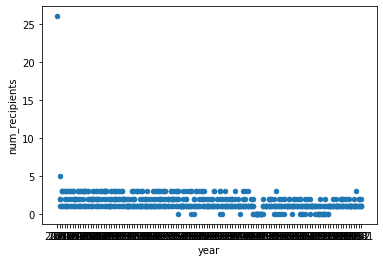

In [79]:
df_awards_nonull.plot.scatter(x='year', y='num_recipients')


Let's aggregate by year. It's just python, so we can keep stringing up those functions.

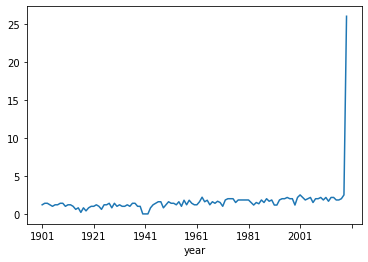

In [80]:
df_awards_nonull.groupby('year').num_recipients.mean().plot.line()


In [81]:
df_awards_nonull[df_awards_nonull.num_recipients>3]

,title,year,recipients,num_recipients,motivation
0,,2020,"[Roger Penrose, Reinhard Genzel, Andrea Ghez, ...",26,Roger Penrose “for the discovery that black ho...
3,The Nobel Prize in Chemistry,2018,"[Frances H. Arnold, George P. Smith, Sir Grego...",5,Frances H. Arnold “for the directed evolution ...


That can't be right. It looks like some weird thing is happening the last few years. Maybe how we process things or maybe the file we got is wrong. 

Check with Google to confirm the data for those 2 years is not correct.

Then, let's remove those years with more than 3 awardees per category.

In [82]:
df_awards_nonull = df_awards_nonull[df_awards_nonull.num_recipients <=3]
df_awards_nonull.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 637 entries, 4 to 640
Data columns (total 5 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   title           637 non-null    object
 1   year            637 non-null    object
 2   recipients      637 non-null    object
 3   num_recipients  637 non-null    int64 
 4   motivation      637 non-null    object
dtypes: int64(1), object(4)
memory usage: 29.9+ KB


How about those years with no recepients in some categories?

Let's remove those too.

In [83]:
df_awards_nonull = df_awards_nonull[df_awards_nonull.num_recipients !=0 ]
df_awards_nonull.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 588 entries, 4 to 640
Data columns (total 5 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   title           588 non-null    object
 1   year            588 non-null    object
 2   recipients      588 non-null    object
 3   num_recipients  588 non-null    int64 
 4   motivation      588 non-null    object
dtypes: int64(1), object(4)
memory usage: 27.6+ KB


Now we have a clean table, but we have given up some data.

We can now study some questions. For example:

**Does the number of winners per category grow over time?**

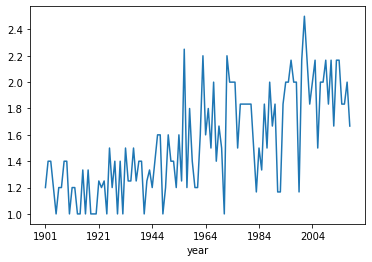

In [86]:
df_awards_nonull.groupby('year').num_recipients.mean().plot.line()

Do you see a trend? How do you confirm that trend?

Home Exercises:

1. The motivation for the prizes in our table now includes both the recepients names and the actual motivation. That's because of the way we grabbed it in the **get_award_motivation** function. Your goal here is to clean up the motivation entries and retain only the portion after the \n character(s).

2. Turns out the data we downloaded is fine, but something went wrong in our parsing. Can you figure out what went wrong and fix it? Hint: some years the awards are given in more complicated ways than others. Study 2020 and 2019 and 2018. You'll find out it is related to 1.